In [1]:
from urban_growth.simulator import *
from urban_growth.estimator import *
from scipy.optimize import approx_fprime
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Generate Some Data

In [44]:
# Initial Configuration
L = 100
rho = .47
blur = 3

# model type
model = 'logistic'

# rural-to-urban threshold
T_vec = [100]

# dynamical parameters

pars = {'alpha' : np.array([140, 30]),
#         'pi'    : np.array([.3, .7]),
        'gamma' : np.array([1.0, 2.8]),
        'beta' : np.array([-10])
       }


geo = np.ones((L, L))

# for i in np.arange(0, L):
#     geo[:,i] = 1.0*i / L 

Step 1 completed


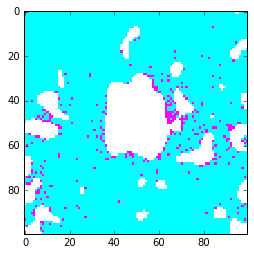

In [45]:
M0 = random_mat(L, rho, blur = blur)
m = simulator(M0 = M0, geo = geo, model = model)

M1 = m.dynamics(T_vec = T_vec,
                n_iters = 1, 
                verbose = True,  
                **pars)

X = M1 - m.M0
X[m.M0 == 1] = np.nan
plt.imshow(X, interpolation = 'nearest', cmap = 'cool')

# First Steps Toward Inference

## Initialize Estimator 

In [46]:
e = estimator(M0 = M0, geo = geo, model = model)
e.update_morphology()
e.partition_clusters(T_vec)
e.make_dist_array(trunc = 50)

In [47]:
e.logistic_log_likelihood(X, normalized = True, use_grad = False, **pars)

-0.11369820464015985

In [48]:
pars_0 = {'alpha' : np.array([50, 80]),
          'gamma' : np.array([3.5, 2.8]), 
          'beta'  : np.array([-2])
       }

pars_hat, ll_hat, h_inv = e.logistic_ML(X, pars_0, use_grad = True, opts = {'disp' : True})

Optimization terminated successfully.
         Current function value: 0.113648
         Iterations: 107
         Function evaluations: 113
         Gradient evaluations: 113


In [50]:
np.set_printoptions(precision=4)
pars_hat

array([ 139.3497,   30.3893,    0.9844,    2.8292,   -9.883 ])

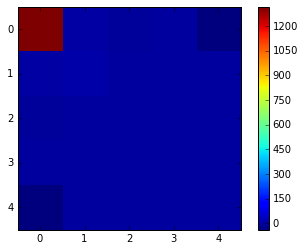

In [43]:
plt.imshow(h_inv / np.nansum(np.isfinite(X)), interpolation='nearest')
plt.colorbar()

In [51]:
np.set_printoptions(precision=2)
np.around(h_inv / np.nansum(np.isfinite(X)), 2)

array([[  2.17e+02,   8.52e+00,  -6.80e-01,   6.40e-01,  -7.96e+00],
       [  8.52e+00,   8.65e+00,  -2.00e-02,   3.50e-01,  -2.60e-01],
       [ -6.80e-01,  -2.00e-02,   0.00e+00,  -0.00e+00,   2.00e-02],
       [  6.40e-01,   3.50e-01,  -0.00e+00,   2.00e-02,  -1.00e-02],
       [ -7.96e+00,  -2.60e-01,   2.00e-02,  -1.00e-02,   3.10e-01]])